In [6]:
%pip install pandas wordcloud nltk textblob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('stopwords')
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mohamed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# FIRST: write the directory for the dataset (no filtering yet!)
data_directory = '/Users/mohamed/Downloads/dataset_for_EDA.csv'

df = pd.read_csv(data_directory, header=0,encoding='latin-1')
df.head()

,Unnamed: 0,total_order,order,year,nominee,speaker_title,speaker_party,speaker_name,speaker_statement
0,0,Total Order,Order,Year,Hearing,Title,Speaker (Party)(or nominated by),Speaker and title,Statements
1,1,1,1,2018,Brett M. Kavanaugh,Chairman,R,Senator Chuck Grassley (IA),Chairman GRASSLEY. I welcome everyone to this ...
2,2,2,2,2018,Brett M. Kavanaugh,Senator,D,Senator Kamala Harris (CA),Senator HARRIS. Mr. Chairman?
3,3,3,3,2018,Brett M. Kavanaugh,Chairman,R,Senator Chuck Grassley (IA),Chairman GRASSLEY [continuing]. Brett Kavanaug...
4,4,4,4,2018,Brett M. Kavanaugh,Senator,D,Senator Kamala Harris (CA),Senator HARRIS. Mr. Chairman?


In [8]:
# SECOND: do the data filtering so that they are split into 
# two datasets. As an example, I am doing Rep/Dem below
dataset1 = df[df["speaker_party"] == "R"]
dataset2 = df[df["speaker_party"] == "D"]

# THIRD: describe your dataset here, this 
# will be the description used on plots
dataset1_label = "Republicans"
dataset2_label = "Democrats"

In [9]:
stop_words = set(stopwords.words('english'))

# OPTIONAL: you may add more stop words if you feel like it 
# (just let me know so that we are on the same page)
custom_stopwords = stop_words.union({'senator', 'judge', 'judges', 'chairman', 'justice'})

# INFO: this will remove the stop words then calculate the tf-idf score
# for each word (the higher the score, the more important the word is)
# and then compare the tf-idf of that word with the opposing dataset.
# The higher the difference, the larger it will appear on the word count.
# Therefore, this represents the words used by one party over the other.
def plot_wordclouds(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    combined_data = pd.concat([dataset1, dataset2])
    dataset1 = dataset1.astype(str)
    dataset2 = dataset2.astype(str)
    combined_data_tokens = combined_data.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in custom_stopwords]))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_tokens)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_matrix1 = tfidf_matrix[:len(dataset1)]
    tfidf_matrix2 = tfidf_matrix[len(dataset1):]
    tfidf_scores1 = np.asarray(tfidf_matrix1.mean(axis=0)).reshape(-1)
    tfidf_scores2 = np.asarray(tfidf_matrix2.mean(axis=0)).reshape(-1)
    tfidf_diff = tfidf_scores1 - tfidf_scores2
    wordcloud1_data = {word: tfidf_scores1[i] for i, word in enumerate(feature_names) if tfidf_diff[i] > 0}
    wordcloud2_data = {word: tfidf_scores2[i] for i, word in enumerate(feature_names) if tfidf_diff[i] < 0}
    wordcloud1 = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(wordcloud1_data)
    wordcloud2 = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(wordcloud2_data)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud1, interpolation='bilinear')
    plt.title('Word Cloud - ' + dataset1_label)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.title('Word Cloud - ' + dataset2_label)
    plt.axis('off')
    plt.show()

# INFO: this represents the top 20 words with the highest differences in tf-idx scores
def plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label, datassave_path=None):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    combined_data = pd.concat([dataset1, dataset2])
    dataset1 = dataset1.astype(str)
    dataset2 = dataset2.astype(str)
    combined_data_tokens = combined_data.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in custom_stopwords]))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_tokens)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_matrix1 = tfidf_matrix[:len(dataset1)]
    tfidf_matrix2 = tfidf_matrix[len(dataset1):]
    tfidf_scores1 = np.asarray(tfidf_matrix1.mean(axis=0)).reshape(-1)
    tfidf_scores2 = np.asarray(tfidf_matrix2.mean(axis=0)).reshape(-1)
    tfidf_diff = tfidf_scores1 - tfidf_scores2
    top_indices = np.argsort(tfidf_diff)[-20:]
    top_words = [feature_names[i] for i in top_indices]
    top_diff_scores = [tfidf_diff[i] for i in top_indices]
    plt.figure(figsize=(10, 8))
    plt.barh(top_words, top_diff_scores, color='skyblue')
    plt.xlabel('Difference in TF-IDF Score')
    plt.title('Top 20 Words with Highest Difference in TF-IDF Score (' + dataset1_label + ' - ' + dataset2_label + ')')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

# INFO: this will produce a side-by-side sentiment analysis of each dataset
def plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    dataset1_sentiments = dataset1.apply(lambda x: TextBlob(x).sentiment.polarity)
    dataset2_sentiments = dataset2.apply(lambda x: TextBlob(x).sentiment.polarity)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset1_sentiments, bins=20, color='skyblue', alpha=0.7)
    plt.title('Sentiment Distribution - ' + dataset1_label)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(dataset2_sentiments, bins=20, color='salmon', alpha=0.7)
    plt.title('Sentiment Distribution - ' + dataset2_label)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()

# INFO: this will produce one plot showing the difference in sentiment between each dataset
def plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    dataset1_sentiments = dataset1.apply(lambda x: TextBlob(x).sentiment.polarity)
    dataset2_sentiments = dataset2.apply(lambda x: TextBlob(x).sentiment.polarity)
    sentiment_difference = dataset1_sentiments - dataset2_sentiments
    sentiment_difference = dataset1_sentiments.sub(dataset2_sentiments, fill_value=0)
    plt.figure(figsize=(8, 6))
    plt.hist(sentiment_difference, bins=20, color='purple', alpha=0.7)
    plt.title('Difference in Sentiment Polarity (' + dataset1_label + ' - ' + dataset2_label + ')')
    plt.xlabel('Sentiment Polarity Difference')
    plt.ylabel('Frequency')
    plt.show()

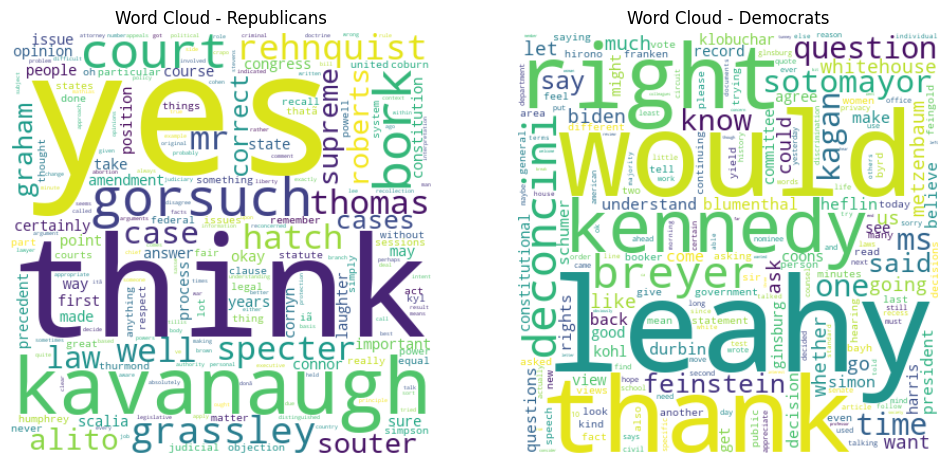

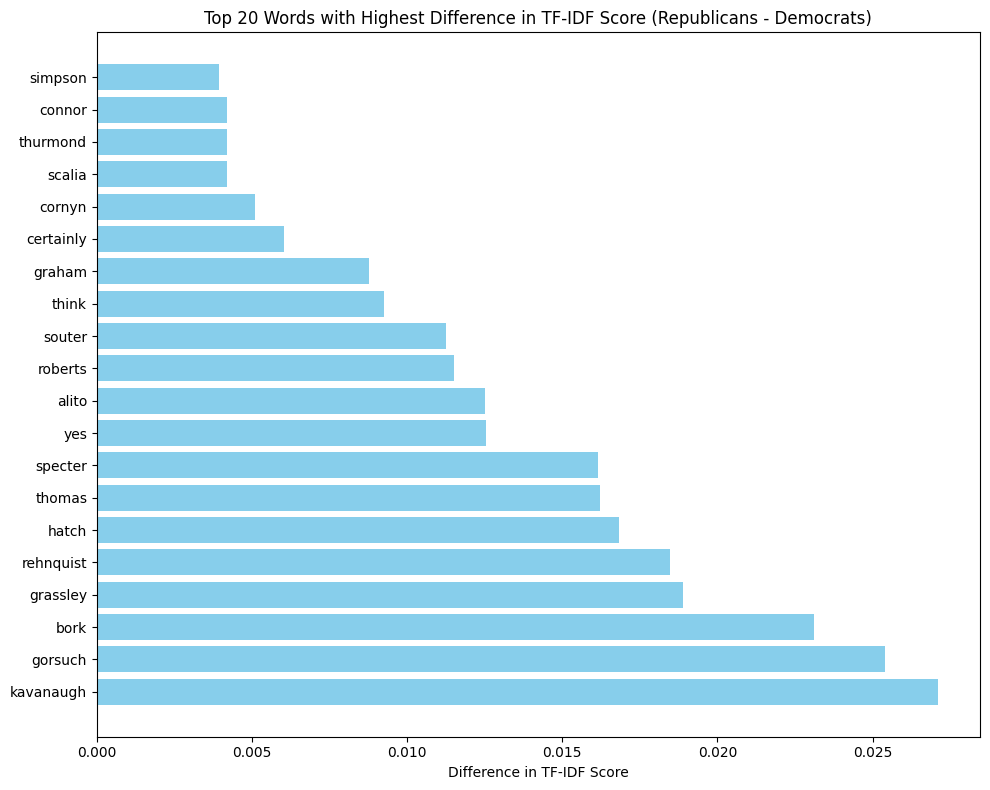

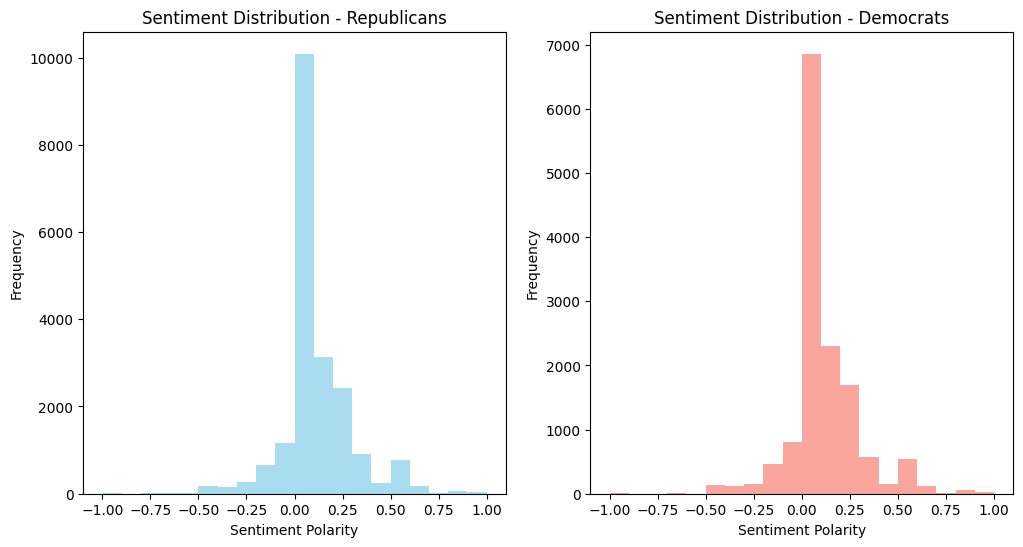

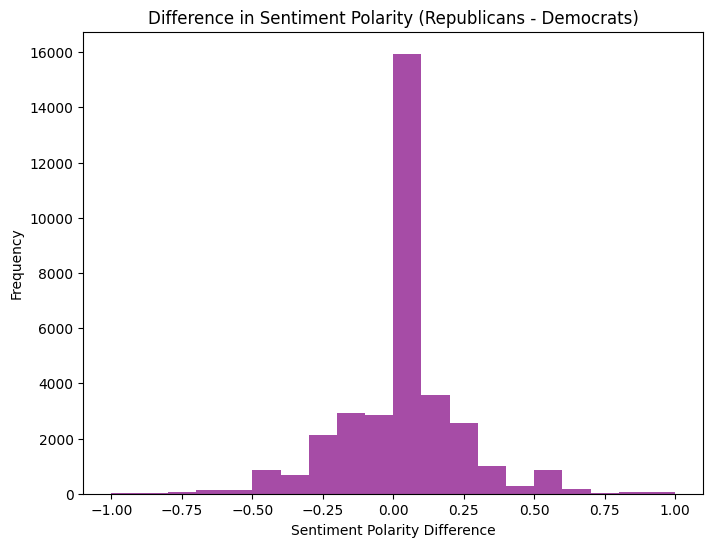

In [10]:
# EDA Factory: ONNNNN
plot_wordclouds(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)